Final Project Goal : 
To use vector fields for Trajectory Planning (not necessarily differential flatness ) 


In [6]:
%pylab inline
plt.style.use('dark_background')
pylab.rcParams['figure.figsize'] = (10.0, 6.0)

Populating the interactive namespace from numpy and matplotlib


C:\Users\rbd218\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [7]:
!pip install JSAnimation

In [11]:
# TODO figure out how this attracting - repelling vector trajectory works 
import numpy as np

# VF wih a limit cycle R³
#http://www.cpdee.ufmg.br/~gpereira/papers/tro2010.pdf
#https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5504176

xc = 0.0
yc = 0.0

# because it is a quadcopter / flying point-robot
zc = 1.0

# radius
r = 3

# weights
wc = 1.0
watt = 3.0


def VF(pos):
    x = pos[0]
    y = pos[1]
    z = pos[2]

    alpha = np.arctan2(y-yc,x-xc)

    # circulating term, unit vector perpencular to the circle
    circ = np.zeros(3)
    circ[0] = -np.sin(alpha)
    circ[1] = np.cos(alpha)

    # attracting term, unit vector towards the ring
    xt = xc-x
    yt = yc-y
    zt = zc-z
    l = np.linalg.norm([xt,yt])
    
    att = (l-r)/l*np.array([xt,yt,0])
    att[2] = zt
    
    vec =  wc*circ+watt*att
    
    # print("vec", vec)
    # print("vec norm", vec/np.linalg.norm(vec))
    return vec/np.linalg.norm(vec) 

def VFangle(pos):
    v = VF(pos)
    a = np.arctan2(v[1],v[0]) # this is vy and vx and returns theta 
 
    return a
  
    

In [12]:
# RK4 for time-invariant function f, stepsize h and initial configuration y0
# Runge–Kutta methods
# In numerical analysis, the Runge–Kutta methods are a family of implicit and explicit iterative methods, 
# which include the well-known routine called the Euler Method, used in temporal discretization for 
# the approximate solutions of ordinary differential equations

# function , intial condition, time interval
# Integration Algorithm: 4th Order Runge Kutta
def rk4_int(f,y0,h):
    # Nyström modification of the fourth-order Runge-Kutta method
    k1=f(y0)
    k2=f(y0+h/2*k1)
    k3=f(y0+h/2*k2)
    k4=f(y0+h*k3)
    
    # Runge–Kutta methods
    # https://www.codeproject.com/articles/18922/solving-a-differential-equation
    # the Runge-Kutta method finds the next value yn+1 from the present value yn with the help of following equation:
    # yn+1 = yn + h/6 (k1 + 2 * k2 + 2 * k3 + k4)
    
    '''
    e.g. 
    Knowing the charge q0 at the instant t0, we would like to find the time variation of the charge, 
    which is an unknown function q = q(t). Despite the fact that an analytical formula for this function exists, 
    we want rather to get numerical approximations of q = q(t). Among many methods invented to solve such initial problems,
    fourth-order Runge-Kutta method is very popular. Having a function of the first derivative and an initial condition:

    dy/dt = f(t, y), y(t0) = y0
    where h is a selected time interval and coefficients k1 to k4 are:

    k1 = f(tn, yn)
    k2 = f(tn + h/2, yn + h/2 k1)
    k3 = f(tn + h/2, yn + h/2 k2)
    k4 = f(tn + h, yn + h k3)
    '''
    
    return y0+h/6*(k1+2*k2+2*k3+k4)


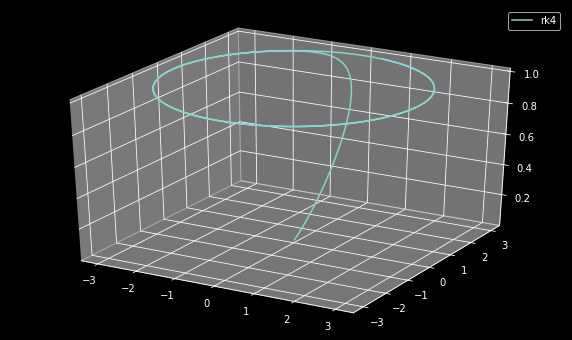

In [13]:
# Show the VF integral
# just show some integral curve
# from scipy.integrate import odeint
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


pos = [.01, .01, .01]

def f(pos,t0):
    return VF(pos)*0.1

#curve2 = odeint(func=f,y0=pos,t=range(0,400))
curve=np.empty([4000,3])
velocity=np.empty([4000,3])
for i in range(0,4000):
    curve[i,:] = pos  
    # To get velocity at current position
    velocity[i,:] = VF(pos)
    # To get updates estimated next position
    pos = rk4_int(VF, pos ,.01) # last term makes it multiple cycles  3- multiple --.001 straight line
    # the rk4_int gets the next position could use this for pid control

#mpl.rcParams['legend.fontsize'] = 10


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(curve[:,0], curve[:,1], curve[:,2], label='rk4')
ax.legend()



plt.show()

In [14]:
def simulate(delta_t, x, u): 
    # x = np.add(x, delta_t * u)
    x += delta_t * u
    return x 

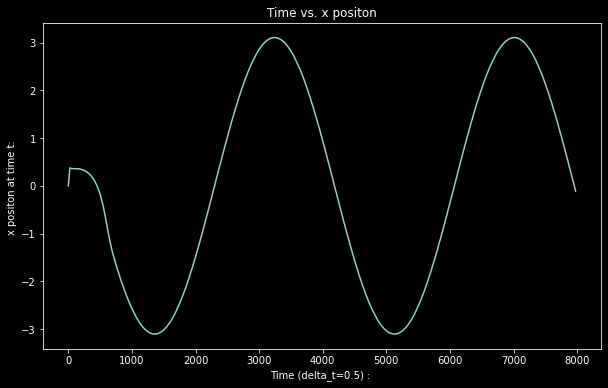

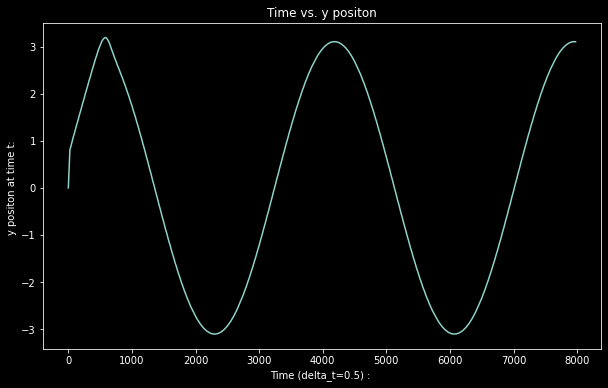

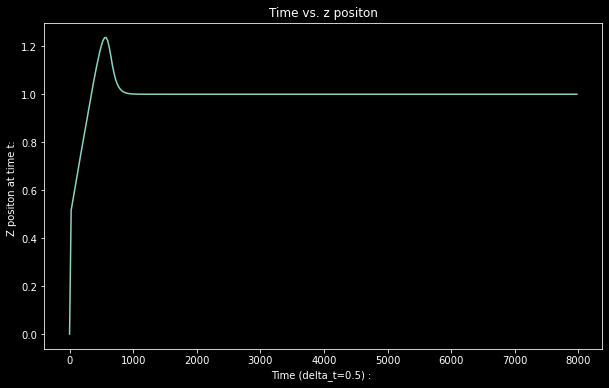

In [15]:

'''
We give a position to the vectory field function which outputs a velocity for the desired trajectory
we use the RK4 method using the VF and intial condition info we estimate the next desired positions 
then use an SE(3) controller to get the point robot to move along that path - plot the actual trajectory
and the desired trajectory 
'''
# Using an SE(3) Controller to get to the desired position 
# plot the actural trajectory vs. the controller trajectory 

h, w = curve.shape[ : 2]
time_intervals = []
positions = []
dx = np.array([0, 0, 0, 0., 0., 0.])

# gains 
kp_x = 5
kd_x = 4
kp_z= 5
kd_z = 4 
kp_th = 2
kd_th = 3 

# target
target = np.array([0., 0., 0., 0., 0., 0.])  
# current
current_pose = np.array([0., 0., 0., 0., 0., 0.])

run_time  = 2
delta_t = .5 # in seconds 
t_total = 0
# if I skipped here the plot becomes less smooth and wavy for some reason so I just remove them after controling it 
for i in range(h):
    t = 0
    while t < run_time :
        target[:3] = curve[i]
        target[3:] = velocity[i]
        
        ax = kp_x * (target[0] - current_pose [0]) + kd_x * (target[3] - current_pose[3])
        az = kp_z * (target[1] - current_pose [1]) + kd_z * (target[4] - current_pose[4])
        ath = kp_th * (target[2] - current_pose [2]) + kd_th * (target[5] - current_pose[5])

        th = current_pose [2]
        dx[:3] = current_pose[3:]
        dx[3:] = [ax, az, ath]
        current_pose = simulate(delta_t, current_pose , dx)

        positions.append(np.copy(current_pose))
        time_intervals.append(t_total)
        t_total =  t_total + delta_t
        t = t + delta_t 


 
plt.title('Time vs. x positon')
plt.xlabel('Time (delta_t=0.5) : ')
plt.ylabel('x positon at time t: ')

xs = np.array(positions)
x = xs[0::50]
ts =  np.array(time_intervals)
time = ts[0::50]
plt.plot(time,    x[:,0])


plt.show()
 


plt.title('Time vs. y positon')
plt.xlabel('Time (delta_t=0.5) : ')
plt.ylabel('y positon at time t: ')


plt.plot(time,    x[:,1])


plt.show()
 

    
plt.title('Time vs. z positon')
plt.xlabel('Time (delta_t=0.5) : ')
plt.ylabel('Z positon at time t: ')


plt.plot(time,    x[:,2])


plt.show()
 

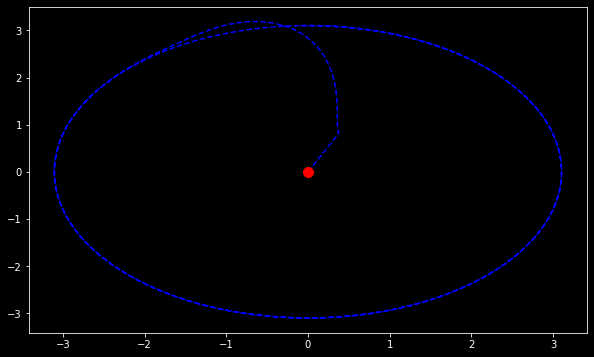

In [16]:
# https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Trajectories.ipynb
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

def animate(t):
    ax.clear()
    
    # Path
    ax.plot(x[:,0], x[:,1], 'b--')
    
    # Initial conditions
    ax.plot(x[:,0][0],x[:,1][0], 'go')
    # ax.quiver(X,Y, Vx, Vy, color='0.4', scale=20)
        
    # Dynamic position
    ax.plot(x[:,0][t],x[:,1][t], 'ro', markersize=10)
       
    # Velocity vector
    # ax.quiver([theta_x[t]], [theta_y[t]], [dx[t]], [dy[t]], color='r', units='xy', scale=10/np.linalg.norm([theta_x[t], theta_y[t]]))
    

anim = animation.FuncAnimation(fig, animate, frames=int(len(x[:,0])/1), interval=25)

'''
Animation size has reached 20987391 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger 
animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). 
This and further frames will be dropped.
'''

HTML(anim.to_jshtml())

In [17]:
# Export the movie to mp4
# Be sure that you have the ffmpeg codec installed (sudo apt-get install ffmpeg).

In [18]:
anim.save('trajectory.mp4', dpi=300)
